# Analyzing connections in Baltimore shooting data

This notebook takes the data standardized in the first step and runs various calculations on it — primarily related to cases connected by a common suspect or victim.

In [1]:
import pandas as pd
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, LineString
from pyproj import Proj, transform
import matplotlib.pyplot as plt

This function lets us write basic findings to a logfile:

In [2]:
def log(obj, description):
    print(description + ":")
    with open("../outputs/log.txt", "a") as f:
        f.write(f"{description}:\n\n{obj}\n\n---\n")
    return obj

## Load persons named in Baltimore database

In [3]:
persons = pd.read_csv("../inputs/baltimore-shootings-persons.csv")

persons.head().T

,0,1,2,3,4
CASE_NUMBER,12V0001,12H0001,12V0002,12V0002,12V0002
CASE_DATE,2012-01-01,2012-01-03,2012-01-03,2012-01-03,2012-01-03
CASE_ADDRESS,500 OAKLAND AV,4000 EDGEWOOD RD,2300 OREM AV,2300 OREM AV,2300 OREM AV
CASE_STATUS,OPEN,OPEN,CLOSED,CLOSED,CLOSED
DESCRIPTION,VICTIM,VICTIM,SUSPECT,SUSPECT,VICTIM
VICT_TYPE,NON FATAL SHOOTING,HOMICIDE SHOOTING,NaN,NaN,NON FATAL SHOOTING
vict_type_generic,NON FATAL SHOOTING,HOMICIDE,NaN,NaN,NON FATAL SHOOTING
case_vict_type_generic,NON FATAL SHOOTING,HOMICIDE,NON FATAL SHOOTING,NON FATAL SHOOTING,NON FATAL SHOOTING
weapon_inferred,Firearm,Firearm,Firearm,Firearm,Firearm
name_is_vague,0,0,0,0,0


# Calculate rolling case-counts and closure rates

In [4]:
def get_annual_rolling_rates(df):
    return (
        df
        [[
            "CASE_DATE",
            "CASE_NUMBER",
            "CASE_STATUS",
        ]]
        .drop_duplicates()
        .assign(
            is_closed = lambda df: df["CASE_STATUS"] == "CLOSED",
            CASE_DATE = lambda df: pd.to_datetime(df["CASE_DATE"])
        )
        .groupby([
            pd.Grouper(
                key = "CASE_DATE",
                freq = "D",
            ),
        ])
        .pipe(lambda grp: pd.DataFrame({
            "incidents_total": grp.size(),
            "incidents_closed": grp["is_closed"].sum(),
        }))
        .fillna(0)
        .astype(int)
        .rolling(365)
        .sum()
        .dropna()
        .assign(
            closure_rate =  lambda df: df["incidents_closed"] / df["incidents_total"]
        )
        .reset_index()
    )

In [5]:
rolling_annual_case_counts = (        
    persons
    .loc[lambda df: df["VICT_TYPE"] == "NON FATAL SHOOTING"]
    .pipe(get_annual_rolling_rates)
    [[ "CASE_DATE", "closure_rate" ]]
    .merge(
        persons
        .loc[lambda df: df["VICT_TYPE"] == "HOMICIDE SHOOTING"]
        .pipe(get_annual_rolling_rates)
        [[ "CASE_DATE", "closure_rate" ]],
        on = [ "CASE_DATE" ],
        how = "left",
        suffixes = [ "_nonfatal", "_fatal" ]
    )
    .merge(
        persons
        .pipe(get_annual_rolling_rates)
        [[ "CASE_DATE", "incidents_total" ]],
        how = "left",        
        on = [ "CASE_DATE" ],
        suffixes = [ "_nonfatal", "_fatal" ]
    )
    .set_index("CASE_DATE")
    .loc["2013":"2016"]
    .astype({ "incidents_total": int })
)

rolling_annual_case_counts.to_csv(
    "../outputs/baltimore-rolling-case-counts-and-closure-rate.csv"
)

rolling_annual_case_counts.head()

,closure_rate_nonfatal,closure_rate_fatal,incidents_total
CASE_DATE,,,
2013-01-01,0.513678,0.375000,483
2013-01-02,0.513678,0.377143,482
2013-01-03,0.513678,0.377143,482
2013-01-04,0.519637,0.377143,484
2013-01-05,0.518182,0.379310,482


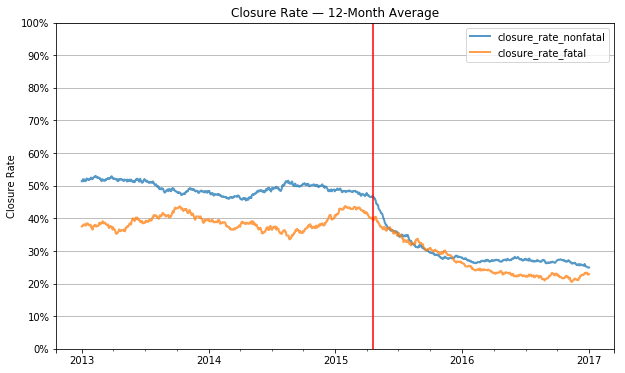

In [6]:
fig, ax = plt.subplots(
    figsize = (10, 6),
)

(
    rolling_annual_case_counts
    [[
        "closure_rate_nonfatal",
        "closure_rate_fatal"
    ]]
    .plot(
        ax = ax,
        lw = 2,
        alpha = 0.75
    )
)

ax.figure.set_facecolor("white")

ax.yaxis.grid()
ax.set_yticks(pd.np.arange(0, 1.1, 0.1))
ax.set_yticklabels([ "{:.0f}%".format(y * 100)
    for y in ax.get_yticks() ])

ax.set_xlabel(None)
ax.set_ylabel("Closure Rate")
ax.set_title("Closure Rate — 12-Month Average")

ax.set_ylim(0, 1)
ax.axvline("2015-04-19", color = "red")
pass

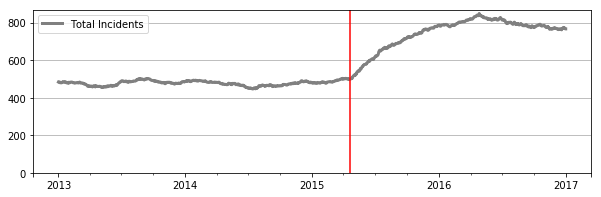

In [7]:
fig, ax = plt.subplots(
    figsize = (10, 3),
)

(
    rolling_annual_case_counts
    ["incidents_total"]
    .plot(
        lw = 3,
        color = "gray"
    )
)

ax.axvline("2015-04-19", color = "red")

ax.set_ylim(0, None)
ax.yaxis.grid(True)

ax.figure.set_facecolor("white")

ax.set_xlabel(None)
ax.set_xticks(ax.get_xticks())

ax.legend(["Total Incidents"])
pass

In [8]:
log((    
    rolling_annual_case_counts
    .loc["2015-04-19"]
    ["incidents_total"]
), "Number of shooting cases in 12-month period ending 2015-04-19")

Number of shooting cases in 12-month period ending 2015-04-19:


498.0

In [9]:
log((    
    rolling_annual_case_counts
    .loc["2016-04-19"]
    ["incidents_total"]    
), "Number of shooting cases in 12-month period ending 2016-04-19")

Number of shooting cases in 12-month period ending 2016-04-19:


839.0

In [10]:
persons["CASE_STATUS"].value_counts()

OPEN            3248
CLOSED          2903
OPEN/WARRANT      12
Name: CASE_STATUS, dtype: int64

In [11]:
# Ensure that there's only one case status per incident
assert (
    persons
    .groupby([
        "CASE_NUMBER",
    ])
    ["CASE_STATUS"]
    .nunique()
    .max()
) == 1

In [12]:
log(round((
    persons
    .loc[lambda df: df["CASE_DATE"] >= "2015-04-20"]
    .loc[lambda df: df["CASE_DATE"] < "2016"]
    [[
        "CASE_NUMBER",
        "CASE_STATUS"
    ]]
    .drop_duplicates()
    .pipe(lambda df: df["CASE_STATUS"] == "CLOSED")
    .mean()
), 3), "Closure rate for cases from April 20, 2015 through end of 2015")

Closure rate for cases from April 20, 2015 through end of 2015:


0.253

In [13]:
log(round(
    persons
    .loc[lambda df: df["CASE_DATE"] >= "2015"]
    .loc[lambda df: df["CASE_DATE"] < "2017"]
    [[
        "CASE_NUMBER",
        "CASE_STATUS"
    ]]
    .drop_duplicates()
    .pipe(lambda df: df["CASE_STATUS"] == "OPEN")
    .sum()
), "Cases from 2015 and 2016 marked 'OPEN', as of mid-2017")

Cases from 2015 and 2016 marked 'OPEN', as of mid-2017:


1146

## Calculate basic statistics on cases, suspects, and victims

In [14]:
log((    
    persons["CASE_NUMBER"].nunique()
), "Number of distinct case numbers")

Number of distinct case numbers:


3479

In [15]:
log((    
    persons["CASE_DATE"].min()
), "Earliest case date")

Earliest case date:


'2012-01-01'

In [16]:
log((    
    persons["CASE_DATE"].max()
), "Latest case date")

Latest case date:


'2017-07-26'

In [17]:
log(round((
    persons
    .loc[lambda df: df["DESCRIPTION"] == "SUSPECT"]
    .loc[lambda df: df["name_is_vague"] == 0]
    ["CASE_NUMBER"]
    .nunique() 
    / 
    persons["CASE_NUMBER"].nunique()
), 3), "Proportion of cases with a named suspect")

Proportion of cases with a named suspect:


0.354

In [18]:
(
    persons
    .loc[lambda df: df["DESCRIPTION"] == "VICTIM"]
    ["VICT_TYPE"]
    .value_counts(normalize = True)
    .round(3)
    .pipe(log, "Proportion of victims by victim type")
)

Proportion of victims by victim type:


NON FATAL SHOOTING    0.69
HOMICIDE SHOOTING     0.31
Name: VICT_TYPE, dtype: float64

In [19]:
(
    persons
    .loc[lambda df: df["DESCRIPTION"] == "SUSPECT"]
    ["case_vict_type_generic"]
    .value_counts(normalize = True)
    .round(3)
    .pipe(log, "Proportion of suspects by victim type")
)

Proportion of suspects by victim type:


NON FATAL SHOOTING               0.642
HOMICIDE                         0.294
HOMICIDE + NON FATAL SHOOTING    0.064
Name: case_vict_type_generic, dtype: float64

In [20]:
(
    persons
    .loc[lambda df: df["DESCRIPTION"] == "VICTIM"]
    ["RACE"]
    .value_counts(normalize = True)
    .round(3)
    .pipe(log, "Proportion of victims by race")
)

Proportion of victims by race:


BLACK       0.946
WHITE       0.037
HISPANIC    0.010
OTHER       0.004
UNKNOWN     0.001
ASIAN       0.001
Name: RACE, dtype: float64

## Connect cases via shared victims/suspects

In [21]:
# Here, we remove "persons of interest", and also deduplicate the handful
# of suspects who are listed more than once for the same case

person_victims_and_suspects = (   
    persons
    .loc[lambda df: df["DESCRIPTION"] != "PERSON OF INTEREST"]
    [[
        "CASE_NUMBER",
        "CASE_DATE",
        "DESCRIPTION",
        "VICT_TYPE",
        "person_uid"
    ]]
    .drop_duplicates()
)

person_victims_and_suspects.head()

,CASE_NUMBER,CASE_DATE,DESCRIPTION,VICT_TYPE,person_uid
0,12V0001,2012-01-01,VICTIM,NON FATAL SHOOTING,41b10e399d
1,12H0001,2012-01-03,VICTIM,HOMICIDE SHOOTING,031694ec35
2,12V0002,2012-01-03,SUSPECT,NaN,c879b0a6cf
3,12V0002,2012-01-03,SUSPECT,NaN,eaa8feed13
4,12V0002,2012-01-03,VICTIM,NON FATAL SHOOTING,92f7c6f0fc


By joining the persons data to itself, we can identify instances where two cases share a common person — someone who is either a suspect or victim in both cases (although not necessarily the same role in both):

In [22]:
case_connections = (
    person_victims_and_suspects
    .drop(columns = [ "VICT_TYPE", "CASE_DATE" ])
    .pipe(lambda df: (
        df
        .merge(
            df,
            how = "left",
            on = [ "person_uid" ]
        )
    ))
    # Here, we limit the results to those where the matching case
    # is higher in the sort-order than the starting case,
    # to remove duplicates and self-matches
    .loc[lambda df: df["CASE_NUMBER_x"] < df["CASE_NUMBER_y"]]
)

case_connections.head()

,CASE_NUMBER_x,DESCRIPTION_x,person_uid,CASE_NUMBER_y,DESCRIPTION_y
1,12V0001,VICTIM,41b10e399d,15H0158,SUSPECT
10,12V0004,SUSPECT,bcccebaf16,15V0212,SUSPECT
22,12V0009,SUSPECT,c47907e1d1,12V0021,SUSPECT
24,12V0009,VICTIM,3b75669caf,15V0439,VICTIM
40,12V0017,VICTIM,5105212289,12V0206,VICTIM


In [23]:
log((    
    case_connections
    ["person_uid"]
    .nunique()
), "Number of people connected to multiple cases")

Number of people connected to multiple cases:


434

In [24]:
(
    pd.concat([
        case_connections["CASE_NUMBER_x"],
        case_connections["CASE_NUMBER_y"],
    ])
    .to_frame("CASE_NUMBER")
    .nunique()
    .pipe(log, "Number of shootings (unique_case_numbers) connected by a common victim/suspect")
)

Number of shootings (unique_case_numbers) connected by a common victim/suspect:


CASE_NUMBER    826
dtype: int64

In [25]:
connected_cases = (
    case_connections
    [[
        "CASE_NUMBER_x",
        "CASE_NUMBER_y"
    ]]
    .drop_duplicates()
)

connected_cases.head()

,CASE_NUMBER_x,CASE_NUMBER_y
1,12V0001,15H0158
10,12V0004,15V0212
22,12V0009,12V0021
24,12V0009,15V0439
40,12V0017,12V0206


Here we create a network graph (via `networkx`) to identify groups of cases connected to one another — directly or indirectly:

In [26]:
graph = nx.Graph()

graph.add_edges_from(
    connected_cases
    [[
        "CASE_NUMBER_x",
        "CASE_NUMBER_y"
    ]]
    .apply(tuple, axis = 1)
    .values
)

In [27]:
groups = pd.concat([
    pd.DataFrame([ { "CASE_NUMBER": x, "group": i }  for x in subset ])
    for i, subset in enumerate(nx.connected_components(graph)) 
])

groups.head()

,CASE_NUMBER,group
0,12V0001,0
1,15H0158,0
0,15V0212,1
1,12V0004,1
0,16H0293,2


In [28]:
log((
    groups["group"].nunique()
), "Number of groups of connected shootings")

Number of groups of connected shootings:


333

The table below counts the proportion of grouped cases of each size — 76% of groups are just two cases; 14% are groups of three cases, 5% are groups of four cases, et cetera:

In [29]:
(
    groups
    ["group"]
    .value_counts()
    .value_counts(normalize = True)
    .sort_index()
    .to_frame("proportion")
)

,proportion
2,0.759760
3,0.141141
4,0.054054
5,0.021021
6,0.006006
7,0.006006
8,0.006006
13,0.003003
17,0.003003


## Calculate statistics about these groups

Most of the groups involve both a fatal and non-fatal shooting:

In [30]:
(
    person_victims_and_suspects
    .loc[lambda df: df["DESCRIPTION"] == "VICTIM"]
    .merge(
        groups,
        on = "CASE_NUMBER",
        how = "left",
        validate = "m:1"
    )
    .dropna(subset = [ "group" ])
    .groupby([
        "group"
    ])
    ["VICT_TYPE"]
    .unique()
    .apply(sorted)
    .apply(tuple)
    .value_counts()
    .pipe(log, "Connected-shooting groups, by distinct victim types")
)

Connected-shooting groups, by distinct victim types:


(HOMICIDE SHOOTING, NON FATAL SHOOTING)    209
(NON FATAL SHOOTING,)                      101
(HOMICIDE SHOOTING,)                        23
Name: VICT_TYPE, dtype: int64

If you count only the highest-level offense for each case — i.e., only homicide for cases that involved both fatal and non-fatal shootings — the numbers are similar, but slightly different:

In [31]:
highest_level_victim_by_case = (
    persons
    .dropna(subset = [ "VICT_TYPE" ])
    .groupby("CASE_NUMBER")
    ["VICT_TYPE"]
    .min() # Here, `min` selects "HOMICIDE SHOOTING" over "NON FATAL SHOOTING"
    .reset_index()
)

highest_level_victim_by_case.head()

,CASE_NUMBER,VICT_TYPE
0,12H0001,HOMICIDE SHOOTING
1,12H0004,HOMICIDE SHOOTING
2,12H0005,HOMICIDE SHOOTING
3,12H0006,HOMICIDE SHOOTING
4,12H0007,HOMICIDE SHOOTING


In [32]:
(
    highest_level_victim_by_case
    .merge(
        person_victims_and_suspects
        .loc[lambda df: df["DESCRIPTION"] == "VICTIM"],
        how = "left",
        on = "CASE_NUMBER",
        suffixes = [ "_highest", "_individual" ]
    )
    .groupby([
        "VICT_TYPE_highest",
        "VICT_TYPE_individual"
    ])
    .size()
    .to_frame("count")
    .reset_index()
)

,VICT_TYPE_highest,VICT_TYPE_individual,count
0,HOMICIDE SHOOTING,HOMICIDE SHOOTING,1271
1,HOMICIDE SHOOTING,NON FATAL SHOOTING,226
2,NON FATAL SHOOTING,NON FATAL SHOOTING,2600


In [33]:
(
    groups
    .merge(
        highest_level_victim_by_case,
        how = "left",
        on = "CASE_NUMBER",
        validate = "1:1",
    )
    .groupby("group")
    ["VICT_TYPE"]
    .unique()
    .apply(sorted)
    .apply(tuple)
    .value_counts()
    .pipe(log, "Connected-shooting groups, by distinct *highest-level* victim types")    
)

Connected-shooting groups, by distinct *highest-level* victim types:


(HOMICIDE SHOOTING, NON FATAL SHOOTING)    200
(NON FATAL SHOOTING,)                      101
(HOMICIDE SHOOTING,)                        32
Name: VICT_TYPE, dtype: int64

## Calculate statistics about victims and suspects named in multiple cases

Here, we count the number of distinct cases in which someone was listed as a victim, and the same for as a suspect:

In [34]:
connected_person_counts = (
    person_victims_and_suspects
    
    # Select only people who serve as a connection between cases
    .loc[lambda df: df["person_uid"].isin(
        case_connections["person_uid"]
    )]
    [[
        "person_uid",
        "CASE_NUMBER",
        "DESCRIPTION"
    ]]
    .groupby([ "person_uid" ])
    ["DESCRIPTION"]
    .value_counts()
    .unstack()
    .fillna(0)
    .astype(int)
)

connected_person_counts.head()

DESCRIPTION,SUSPECT,VICTIM
person_uid,,
001868b860,1,5
003d0b0827,1,1
00832f78c1,0,2
008d4ad475,2,0
00b831b181,1,1


In [35]:
log((
    connected_person_counts
    .loc[lambda df: df["SUSPECT"] > 0]
    .loc[lambda df: df["VICTIM"] > 0]
    .pipe(len)
), "People listed as both victims and suspects")

People listed as both victims and suspects:


214

### Victims

In [36]:
log((
    connected_person_counts
    .loc[lambda df: df["VICTIM"] > 1]
    .pipe(len)
), "People listed as victims in multiple cases")

People listed as victims in multiple cases:


171

For people listed as victims in multiple cases, for how many was their final recorded case a homicide vs. non-fatal shooting?:

In [37]:
(
    person_victims_and_suspects
    .loc[lambda df: df["DESCRIPTION"] == "VICTIM"]
    .loc[lambda df: df["person_uid"].isin(
        connected_person_counts
        .loc[lambda df: df["VICTIM"] > 1]
        .index
    )]
    .sort_values("CASE_DATE")
    .groupby("person_uid")
    ["VICT_TYPE"]
    .last()
    .value_counts()
    .pipe(log, "Final victim type for persons shot in multiple incidents")
)

Final victim type for persons shot in multiple incidents:


NON FATAL SHOOTING    92
HOMICIDE SHOOTING     79
Name: VICT_TYPE, dtype: int64

As a sanity-check, the *initial* case types for these victims should all be non-fatal — and they are:

In [38]:
# Same code as above, but replacing `.last()` with `.first()`:
(
    person_victims_and_suspects
    .loc[lambda df: df["DESCRIPTION"] == "VICTIM"]
    .loc[lambda df: df["person_uid"].isin(
        connected_person_counts
        .loc[lambda df: df["VICTIM"] > 1]
        .index
    )]
    .sort_values("CASE_DATE")
    .groupby("person_uid")
    ["VICT_TYPE"]
    .first()
    .value_counts()
    .pipe(log, "Initial victim type for persons shot in multiple incidents")
)

Initial victim type for persons shot in multiple incidents:


NON FATAL SHOOTING    171
Name: VICT_TYPE, dtype: int64

### Suspects

In [39]:
log((
    connected_person_counts
    .loc[lambda df: df["SUSPECT"] > 1]
    .pipe(len)
), "People listed as suspects in multiple cases")

People listed as suspects in multiple cases:


87

Here, we identify cases where at least one of the suspects was also named a suspect in another case:

In [40]:
cases_with_repeat_suspects = (
    person_victims_and_suspects
    .loc[lambda df: (
        df["person_uid"].isin(
            connected_person_counts
            .loc[lambda df: df["SUSPECT"] > 1]
            .index
        ) &
        (df["DESCRIPTION"] == "SUSPECT")
    )]    
    ["CASE_NUMBER"]
    .drop_duplicates()
)

cases_with_repeat_suspects.head()

9     12V0004
20    12V0009
45    12V0021
48    12V0023
91    12V0045
Name: CASE_NUMBER, dtype: object

In [41]:
len(cases_with_repeat_suspects)

182

In [42]:
(
    person_victims_and_suspects
    .loc[lambda df: df["CASE_NUMBER"].isin(cases_with_repeat_suspects)]
    .loc[lambda df: df["DESCRIPTION"] == "VICTIM"]
    ["VICT_TYPE"]
    .value_counts()
    .pipe(log, "Victim counts for cases with multiple-case suspects")
)

Victim counts for cases with multiple-case suspects:


NON FATAL SHOOTING    137
HOMICIDE SHOOTING      88
Name: VICT_TYPE, dtype: int64

## Demographics of people named in multiple cases

There's one person in the data with conflicting information about their sex:

In [43]:
(
    persons
    .loc[lambda df: df["DESCRIPTION"] != "PERSON OF INTEREST"]
    .replace("UNKNOWN", pd.np.nan)        
    .groupby([
        "person_uid"
    ])
    [[ "RACE", "SEX" ]]
    .nunique()
    .sort_values([ "RACE", "SEX" ])
    .loc[lambda df: (df > 1).sum(axis = 1) > 0]
)    

,RACE,SEX
person_uid,,
300d31dee1,1,2


To handle this exception, and to use the person's age at the time of their *last recorded* case, we use the most recent case on file for each person:

In [44]:
cx_latest_demographics = (
    persons
    # Select only persons who serve as connections between cases
    .loc[lambda df: df["person_uid"].isin(case_connections["person_uid"])]
    .sort_values("CASE_DATE", ascending = False)
    .drop_duplicates(subset = [ "person_uid" ])
    .replace("UNKNOWN", pd.np.nan)
    .groupby([
        "person_uid"
    ])
    [[ "RACE", "SEX", "age_at_case", "CASE_DATE" ]]
    .last()
    .reset_index()
)

cx_latest_demographics.head()

,person_uid,RACE,SEX,age_at_case,CASE_DATE
0,001868b860,BLACK,MALE,30.0,2016-02-26
1,003d0b0827,BLACK,MALE,21.0,2015-06-06
2,00832f78c1,BLACK,MALE,26.0,2017-07-18
3,008d4ad475,BLACK,MALE,30.0,2014-12-17
4,00b831b181,BLACK,MALE,26.0,2014-06-16


In [45]:
len(cx_latest_demographics)

434

In [46]:
cx_latest_demographics["age_at_case"].value_counts().sort_index()

16.0     3
17.0    11
18.0    21
19.0    18
20.0    21
21.0    25
22.0    30
23.0    35
24.0    43
25.0    33
26.0    34
27.0    28
28.0    23
29.0    24
30.0    17
31.0    14
32.0    11
33.0     5
34.0     6
35.0     3
36.0     6
37.0     3
38.0     5
39.0     1
40.0     1
41.0     5
42.0     4
45.0     1
49.0     1
50.0     1
59.0     1
Name: age_at_case, dtype: int64

In [47]:
cx_latest_demographics.isnull().sum()

person_uid     0
RACE           0
SEX            0
age_at_case    0
CASE_DATE      0
dtype: int64

In [48]:
assert cx_latest_demographics.isnull().sum().sum() == 0

In [49]:
def classify_age(age):
    if age < 18:
        return "group0: <18"
    if age < 28:
        return "group1: 18–27"
    if age < 38:
        return "group2: 28-37"
    return "group3: 38+"

In [50]:
cx_demographic_groups = (
    cx_latest_demographics
    .assign(
        age_group = lambda df: df["age_at_case"].apply(classify_age)
    )
    .groupby([
        "age_group",
        "SEX",
        "RACE"
    ])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
    .reset_index()
    .assign(
        age_group = lambda df: df["age_group"].str.replace(r".*:", "")
    )
    .set_index("age_group")
    .pipe(log, "Demographic groupings of mulitply-involved persons")
)

cx_demographic_groups

Demographic groupings of mulitply-involved persons:


RACE,SEX,BLACK,WHITE
age_group,,,
<18,MALE,14,0
18–27,FEMALE,3,1
18–27,MALE,282,2
28-37,FEMALE,1,0
28-37,MALE,110,1
38+,MALE,19,1


# Spatial analysis

In this section, we identify connected cases that, based on the addresses provided, appear to cross the Baltimore Police Department's police-district boundaries.

In [51]:
districts = (
    gpd
    .read_file("../inputs/Police_Districts/Police_Districts.shp")
    .to_crs(epsg = 4326)
)

districts

,OBJECTID,District,Dist_Name,geometry
0,1,1,Central,POLYGON ((-76.63322888715999 39.31693932735156...
1,2,2,Southeastern,POLYGON ((-76.52974738020585 39.30757972008217...
2,3,3,Eastern,POLYGON ((-76.59548199054264 39.31666719434681...
3,4,4,Northeastern,"POLYGON ((-76.5296742351015 39.37197190004328,..."
4,5,5,Northern,"POLYGON ((-76.59489865066094 39.3719258499626,..."
5,6,6,Northwestern,POLYGON ((-76.66541434925995 39.36797107454819...
6,7,7,Western,POLYGON ((-76.64744797638099 39.31848085353624...
7,8,8,Southwestern,"POLYGON ((-76.7050505368328 39.31943250702053,..."
8,9,9,Southern,POLYGON ((-76.62805603820759 39.28790371336495...


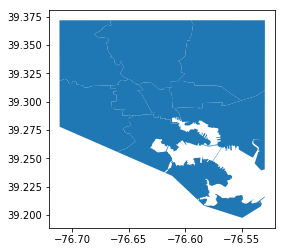

In [52]:
districts.plot();

## Join districts to other spatial data

In [53]:
geocoded_addresses = (
    pd.read_csv(
        "../inputs/baltimore-case-addresses.csv"
    )
    .assign(
        lng = lambda x: x["lng"].fillna(0.0),
        lat = lambda x: x["lat"].fillna(0.0),
    )
    .assign(
        geometry = lambda x: x.fillna(0.0).apply(
            lambda row: Point(row["lng"], row["lat"]),
            axis = 1
        )
    )
    .pipe(gpd.GeoDataFrame)
)

geocoded_addresses.crs = districts.crs

geocoded_addresses.head()

,agency_ori,agency_incident_id,location_address,location_address_adjusted,latlng_method,geocoded_location_interpreted,geocoded_location_type,geocoding_imprecise,lat,lng,tract_2010,tract_state_2010,tract_2000,tract_state_2000,geometry
0,MDBPD0000,17V0351,1700 SHERWOOD AV,"1700 SHERWOOD AV, Baltimore, Maryland, USA",geocoded,"1700 Sherwood Ave, Baltimore, MD 21239, USA",premise,False,39.360424,-76.580990,2.451027e+10,MD,2.451027e+10,MD,POINT (-76.5809905 39.3604239)
1,MDBPD0000,17H0198,1200 GREENMOUNT AV,"1200 GREENMOUNT AV, Baltimore, Maryland, USA",geocoded,"1200 Greenmount Ave, Baltimore, MD 21202, USA",street_address,False,39.303676,-76.608015,2.451010e+10,MD,2.451010e+10,MD,POINT (-76.60801540000001 39.30367570000001)
2,MDBPD0000,17V0349,1700 W LOMBARD ST,"1700 W LOMBARD ST, Baltimore, Maryland, USA",geocoded,"1700 W Lombard St, Baltimore, MD 21223, USA",street_address,False,39.286505,-76.643832,2.451019e+10,MD,2.451019e+10,MD,POINT (-76.64383199999997 39.286505)
3,MDBPD0000,17V0348,1300 WOODBOURNE AV,"1300 WOODBOURNE AV, Baltimore, Maryland, USA",geocoded,"1300 Woodbourne Ave, Baltimore, MD 21239, USA",street_address,False,39.354395,-76.593172,2.451027e+10,MD,2.451027e+10,MD,POINT (-76.593172 39.3543949)
4,MDBPD0000,17V0346,3600 HAYWARD AV,"3600 HAYWARD AV, Baltimore, Maryland, USA",geocoded,"3600 Hayward Ave, Baltimore, MD 21215, USA",street_address,False,39.348306,-76.681842,2.451027e+10,MD,2.451027e+10,MD,POINT (-76.681842 39.348306)


In [54]:
incident_locations = (    
    geocoded_addresses
    .pipe(
        gpd.sjoin,
        districts
        [[
            "Dist_Name",
            "geometry"
        ]].rename(columns = {
            "Dist_Name": "police_district",
        }),
        how = "left",
    )
    .drop(columns = [
        "index_right"
    ])
    [[
        "agency_incident_id",
        "location_address",
        "latlng_method",
        "geocoded_location_interpreted",
        "geocoded_location_type",
        "geocoding_imprecise",
        "geometry",
        "police_district"
    ]]
    .drop_duplicates(subset = [
        "agency_incident_id",
        "geocoded_location_interpreted"
    ])
)

incident_locations.head()

,agency_incident_id,location_address,latlng_method,geocoded_location_interpreted,geocoded_location_type,geocoding_imprecise,geometry,police_district
0,17V0351,1700 SHERWOOD AV,geocoded,"1700 Sherwood Ave, Baltimore, MD 21239, USA",premise,False,POINT (-76.5809905 39.3604239),Northeastern
1,17H0198,1200 GREENMOUNT AV,geocoded,"1200 Greenmount Ave, Baltimore, MD 21202, USA",street_address,False,POINT (-76.60801540000001 39.30367570000001),Eastern
2,17V0349,1700 W LOMBARD ST,geocoded,"1700 W Lombard St, Baltimore, MD 21223, USA",street_address,False,POINT (-76.64383199999997 39.286505),Southern
3,17V0348,1300 WOODBOURNE AV,geocoded,"1300 Woodbourne Ave, Baltimore, MD 21239, USA",street_address,False,POINT (-76.593172 39.3543949),Northeastern
4,17V0346,3600 HAYWARD AV,geocoded,"3600 Hayward Ave, Baltimore, MD 21215, USA",street_address,False,POINT (-76.681842 39.348306),Northwestern


In [55]:
(
    person_victims_and_suspects
    .loc[lambda df: df["DESCRIPTION"] == "VICTIM"]
    .pipe(len)
)

4097

In [56]:
assert incident_locations["agency_incident_id"].nunique() == len(incident_locations)

In [57]:
(
    incident_locations
    ["police_district"]
    .fillna("[blank]")
    .value_counts()
)

Western         595
Southwestern    500
Eastern         498
Northeastern    431
Northwestern    408
Southern        377
Northern        233
Central         230
Southeastern    206
[blank]           1
Name: police_district, dtype: int64

In [58]:
(
    geocoded_addresses
    ["geocoding_imprecise"]
    .fillna("[blank]")
    .value_counts()
)

False    3477
True        2
Name: geocoding_imprecise, dtype: int64

Note: Per above, there is one incident not geocoded to within a Baltimore police district. The address appears to be just outside district lines. (It is not a case connected to others in this analysis.) There are also two addresses that Google's API reported could only be imprecisely geocoded; all plausible locations for each of those addresses, however, are contained within a single police district.

## Analyze geography of connected cases

In [59]:
# Identify the districts for each of the cases,
# for any two connected cases
connected_cases_districts = (
    connected_cases
    .merge(
        groups[[ "CASE_NUMBER", "group" ]],
        how = "left",
        left_on = [ "CASE_NUMBER_x" ],
        right_on = [ "CASE_NUMBER" ],
        validate = "m:1",        
    )
    .drop(columns = [ "CASE_NUMBER" ])
    .merge(
        incident_locations[[ "agency_incident_id", "geometry", "police_district" ]],
        how = "left",
        left_on = [ "CASE_NUMBER_x" ],
        right_on = [ "agency_incident_id" ],
        validate = "m:1",
    )
    .drop(columns = [ "agency_incident_id" ])
    .merge(
        incident_locations[[ "agency_incident_id", "geometry", "police_district" ]],
        how = "left",
        left_on = [ "CASE_NUMBER_y" ],
        right_on = [ "agency_incident_id" ],
        validate = "m:1",        
    )
    .drop(columns = [ "agency_incident_id" ])
)

connected_cases_districts.head()

,CASE_NUMBER_x,CASE_NUMBER_y,group,geometry_x,police_district_x,geometry_y,police_district_y
0,12V0001,15H0158,0,POINT (-76.60951490000002 39.3436344),Northern,POINT (-76.57904090000002 39.3003647),Eastern
1,12V0004,15V0212,1,POINT (-76.59725659999999 39.3608588),Northern,POINT (-76.59726739999998 39.3671029),Northern
2,12V0009,12V0021,2,POINT (-76.64136069999998 39.2922586),Western,POINT (-76.64390970000002 39.287482),Southern
3,12V0009,15V0439,2,POINT (-76.64136069999998 39.2922586),Western,POINT (-76.64897599999998 39.2906135),Western
4,12V0017,12V0206,3,POINT (-76.622078 39.24608200000001),Southern,POINT (-76.62741219999999 39.306631),Central


In [60]:
log(
    connected_cases_districts
    .pipe(lambda df: df["police_district_x"] != df["police_district_y"])
    .mean()
    .round(3),
    "Proportion of *case connections* that are multi-district"
)

Proportion of *case connections* that are multi-district:


0.426

In [61]:
(    connected_cases_districts
    .assign(
        same_district = lambda df: df["police_district_x"] == df["police_district_y"]
    )
    .melt(
        id_vars = [ "same_district" ],
        value_vars = [ "CASE_NUMBER_x", "CASE_NUMBER_y" ]
    )
     .groupby(["value"])
    ["same_district"]
    .mean()
    .pipe(lambda x: (x < 1).mean())
    .round(3),
)

(0.469,)

In [62]:
log(
    connected_cases_districts
    .assign(
        same_district = lambda df: df["police_district_x"] == df["police_district_y"]
    )
    .melt(
        id_vars = [ "same_district" ],
        value_vars = [ "CASE_NUMBER_x", "CASE_NUMBER_y" ]
    )
    .groupby(["value"])
    ["same_district"]
    .mean()
    .pipe(lambda x: (x < 1).mean())
    .round(3),
    "Proportion of *connected cases* that have at least one out-of-district connection"
)

Proportion of *connected cases* that have at least one out-of-district connection:


0.469

The most common district combinations:

In [63]:
(
    connected_cases_districts
    .groupby([
        "police_district_x",
        "police_district_y",
    ])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)

police_district_y,Central,Eastern,Northeastern,Northern,Northwestern,Southeastern,Southern,Southwestern,Western
police_district_x,,,,,,,,,
Central,12,3,4,0,1,1,1,5,8
Eastern,3,62,6,5,0,1,5,1,6
Northeastern,0,9,36,2,1,1,1,1,5
Northern,0,8,3,17,1,0,1,1,7
Northwestern,3,1,1,4,33,0,3,3,4
Southeastern,2,5,0,0,0,22,0,0,2
Southern,4,4,1,2,0,0,35,8,13
Southwestern,1,1,0,10,8,0,9,54,16
Western,16,5,5,2,1,1,14,11,67


In [64]:
(
    connected_cases_districts
    .loc[lambda df: df["police_district_x"] != df["police_district_y"]]
    .assign(
        combo = lambda df: df[[ "police_district_x", "police_district_y" ]].apply(sorted, axis = 1).apply(tuple)
    )
    ["combo"]
    .value_counts()
    .loc[lambda x: x >= 10]
)

(Southern, Western)             27
(Southwestern, Western)         27
(Central, Western)              24
(Southern, Southwestern)        17
(Eastern, Northeastern)         15
(Eastern, Northern)             13
(Northern, Southwestern)        11
(Eastern, Western)              11
(Northwestern, Southwestern)    11
(Northeastern, Western)         10
Name: combo, dtype: int64

# Mapping

In [65]:
def tee(df, fn, *args, **kwargs):
    fn(df, *args, **kwargs)
    return df

In [66]:
multi_district_lines = gpd.GeoDataFrame(
    connected_cases_districts
    .loc[lambda df: df["police_district_x"] != df["police_district_y"]]
    .assign(
        geometry = lambda df: df[[ "geometry_x", "geometry_y" ]].apply(LineString, axis = 1),
        combo = lambda df: df[[ "police_district_x", "police_district_y" ]].apply(sorted, axis = 1).apply(tuple)        
    )
)

multi_district_lines.head()

,CASE_NUMBER_x,CASE_NUMBER_y,group,geometry_x,police_district_x,geometry_y,police_district_y,geometry,combo
0,12V0001,15H0158,0,POINT (-76.60951490000002 39.3436344),Northern,POINT (-76.57904090000002 39.3003647),Eastern,"LINESTRING (-76.60951490000002 39.3436344, -76...","(Eastern, Northern)"
2,12V0009,12V0021,2,POINT (-76.64136069999998 39.2922586),Western,POINT (-76.64390970000002 39.287482),Southern,"LINESTRING (-76.64136069999998 39.2922586, -76...","(Southern, Western)"
4,12V0017,12V0206,3,POINT (-76.622078 39.24608200000001),Southern,POINT (-76.62741219999999 39.306631),Central,"LINESTRING (-76.622078 39.24608200000001, -76....","(Central, Southern)"
6,12V0021,16H0229,2,POINT (-76.64390970000002 39.287482),Southern,POINT (-76.65175090000002 39.2896611),Western,"LINESTRING (-76.64390970000002 39.287482, -76....","(Southern, Western)"
7,12V0023,14V0303,5,POINT (-76.57993940000001 39.3306399),Northeastern,POINT (-76.59485240000002 39.3019838),Eastern,"LINESTRING (-76.57993940000001 39.3306399, -76...","(Eastern, Northeastern)"


In [67]:
def plot_connected_shootings(df, ax):
    districts.plot(
        ax = ax,
        color = "white",
        edgecolor = "black",
    )
    
    (
        df
        .pipe(tee, lambda df: (
            gpd.GeoDataFrame({
                "geometry": df["geometry_x"]
            })
            .plot(
                ax = ax,
                marker = "o",
                markersize = 8,
                color = "black",
                alpha = 0.3
            )
        ))
        .pipe(tee, lambda df: (
            gpd.GeoDataFrame({
                "geometry": df["geometry_y"]
            })
            .plot(
                ax = ax,
                marker = "o",
                markersize = 8,
                color = "black",
                alpha = 0.3
            )
        ))
        .pipe(tee, lambda df: (
            df[["geometry"]]
            .plot(
                ax = ax,
                alpha = 0.3
            )
        ))    
    )
    
    ax.set_axis_off()

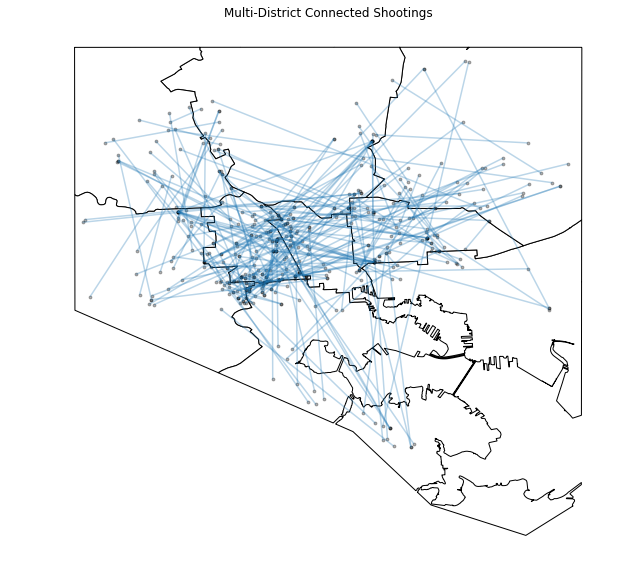

In [68]:
fig, ax = plt.subplots(
    figsize = (10, 10)
)

plot_connected_shootings(multi_district_lines, ax)

ax.set_title("Multi-District Connected Shootings")
pass

---

---

---